前面一章，实现了通过数值微分，求神经网络的损失函数对权重参数的梯度，这种方式很容易实现，但是缺点是计算比较费时间

## 计算图的反向传播

现在有一个 $y=f(x)$ 的计算

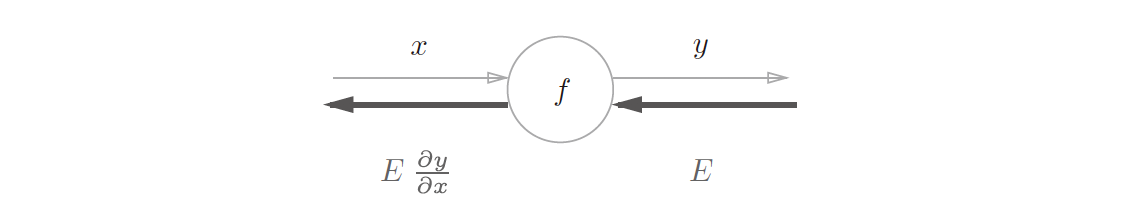

反向传播的计算顺序是，将信号E乘以节点的局部导数 $\frac{\partial y}{\partial x}$，然后将结果传递给下一个节点。这里所说的局部导数是指正向传播
中 $y = f(x)$ 的导数，也就是 $y$ 关于 $x$ 的导数 $\frac{\partial y}{\partial x}$

## 链式法则

**复合函数** 是由多个函数构成的函数，如下面函数 $z=(x+y)^{2}$：$$z=t^{2}$$ $$t=x+y$$

链式法则是关于复合函数的导数的性质，定义如下:

> 如果某个函数由复合函数表示，则该复合函数的导数可以用构成复合函数的各个函数的导数的乘积表示。

就上面的复合函数 $z$ 举例，$$\frac{\partial z}{\partial x}=\frac{\partial z}{\partial t} \frac{\partial t}{\partial x}$$

现在使用链式法则，求 上面的复合函数 $z$ 对 $x$ 的偏导数 $\frac{\partial z}{\partial x}$ 

$$\frac{\partial z}{\partial t}=2 t$$ $$\frac{\partial t}{\partial x}=1$$ 所以，

$$\frac{\partial z}{\partial x}=\frac{\partial z}{\partial t} \frac{\partial t}{\partial x}=2 t \cdot 1=2(x+y)$$

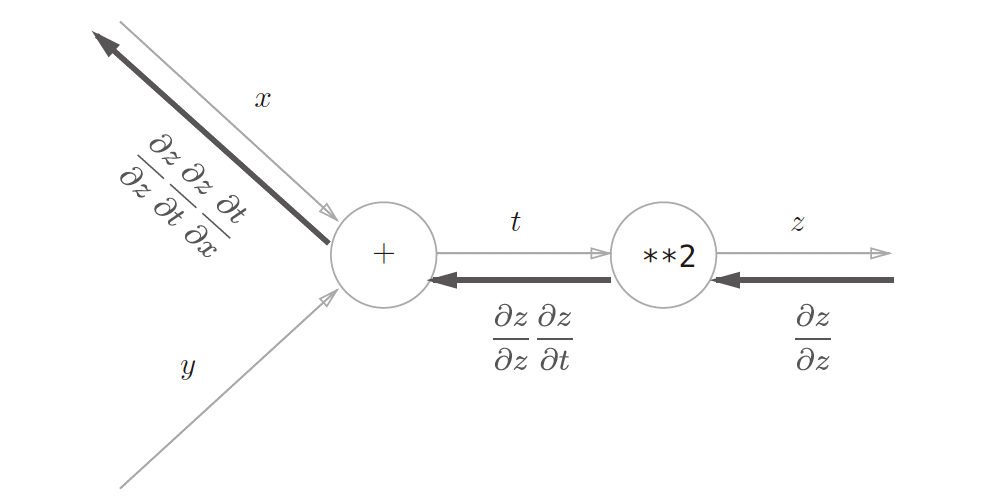

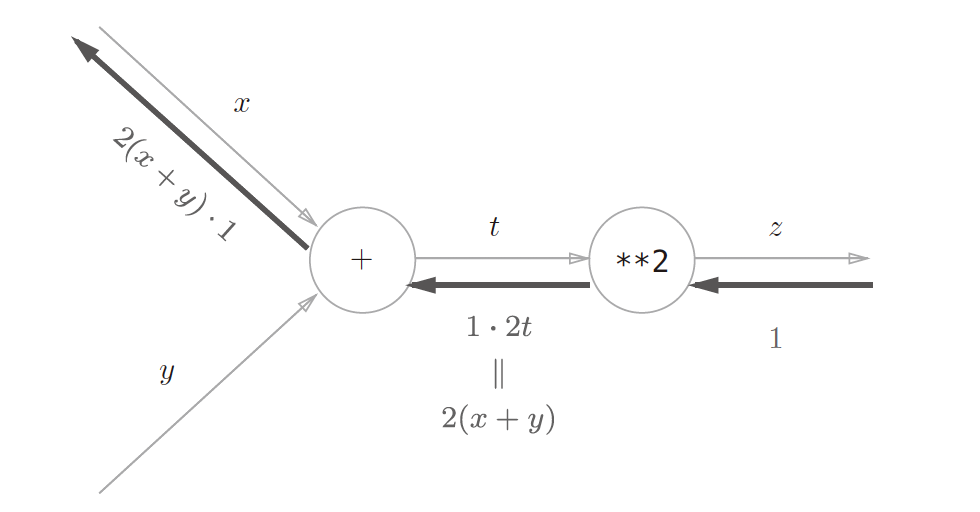

根据计算图的反向传播的结果， $z$ 对 $x$ 的偏导数为 $2(x+y)$

## 反向传播

### 加法节点的反向传播

这里以 $z = x + y$ 为对象，观察它的反向传播。$z = x + y$ 的导数可由下式（解析性地）计算出来， 
$$\frac{\partial z}{\partial x}=1$$ $$\frac{\partial z}{\partial y}=1$$

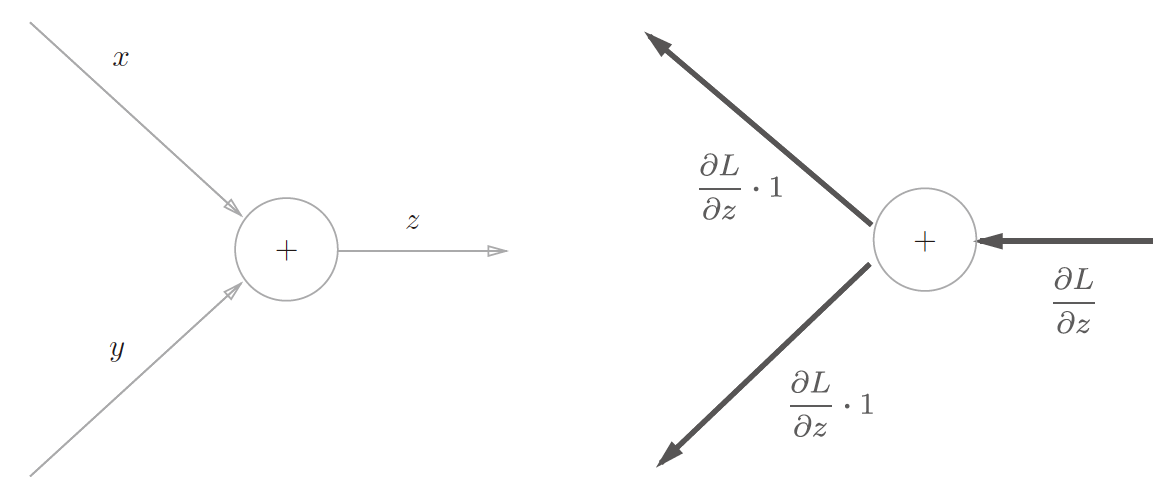

$\frac{\partial L}{\partial z}$ 为上游传递过来的导数，然后传往下游，由于加法 $x + y = z$ 对 $x$ 和 $y$ 的导数均为1，根据链式法则，会将上游传下来的值乘以1流向下一个节点

### 乘法节点的反向传播

这里以 $z=xy$ 为例，这个式子的导数可以用下式表示： $$\frac{\partial z}{\partial x}=y$$ $$\frac{\partial z}{\partial y}=x$$

乘法的反向传播会将上游的值乘以正向传播时的输入信号的“**翻转值**”后传递给下游

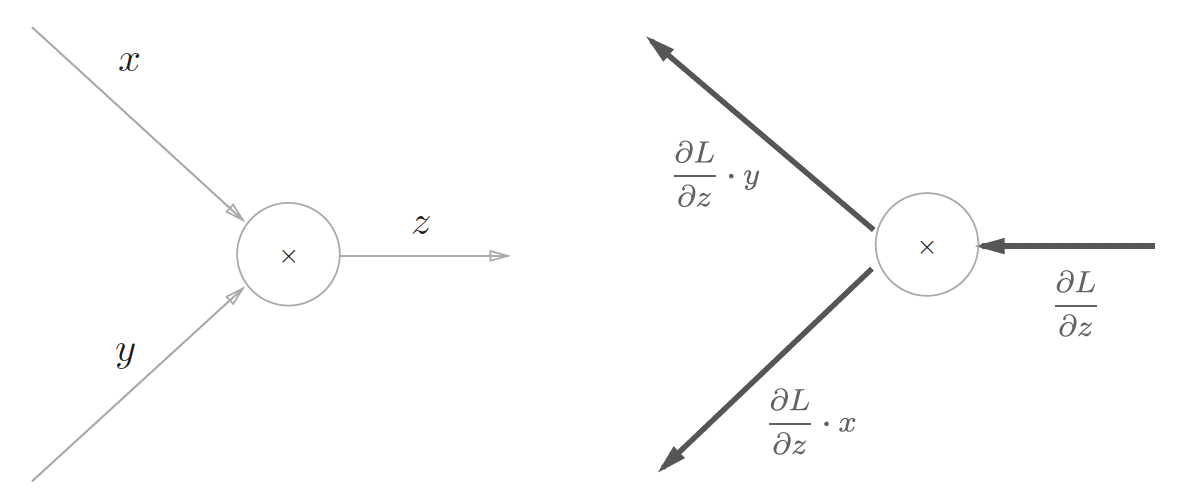

## 简单层的实现

下面实现上面的加法和乘法层

In [1]:
# coding: utf-8

class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x # 记录下向前传播时的输入信号
        self.y = y
        out = x * y
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy


class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1 # 反向传播时将上游信号原封不动传给下游
        dy = dout * 1
        return dx, dy

下面以买苹果和橘子为例子，求最终价格对苹果价格、橘子价格和消费税的偏导数

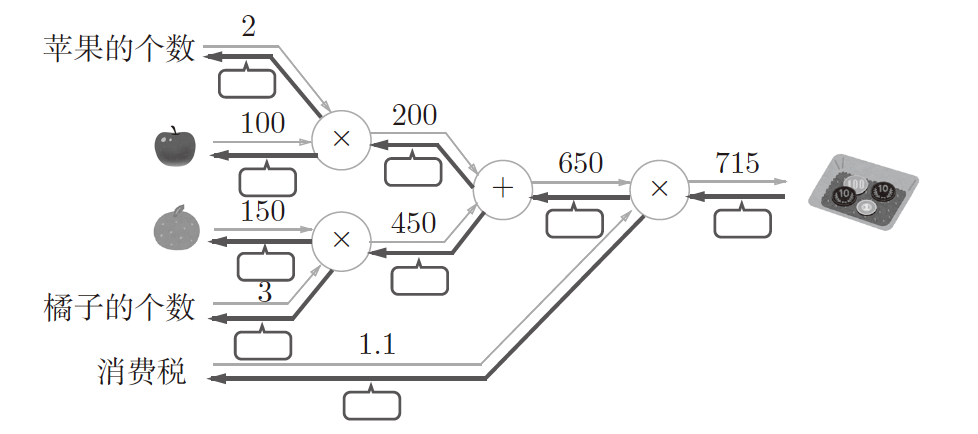

In [2]:
from layer_naive import AddLayer, MulLayer

apple_price, apple_number, orange_price, orange_number, tax = 100, 2, 150, 3, 1.1

# layers
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_total = mul_apple_layer.forward(apple_price, apple_number)
orange_total = mul_orange_layer.forward(orange_price, orange_number)
all_total = add_apple_orange_layer.forward(apple_total, orange_total)
final = mul_tax_layer.forward(all_total, tax)

# backward
dfinal = 1
dall_total, dtax = mul_tax_layer.backward(dfinal)
dapple_total, dorange_total = add_apple_orange_layer.backward(dall_total)
dapple_price, dapple_number = mul_apple_layer.backward(dapple_total)
dorange_price, dorange_number = mul_orange_layer.backward(dorange_total)

#
print(final)
print(dapple_price, dapple_number, dorange_price, dorange_number, dtax)

715.0000000000001
2.2 110.00000000000001 3.3000000000000003 165.0 650


## 激活函数层的实现

### ReLU层的实现

激活函数ReLU（Rectified Linear Unit）由下式表示 $$y=\left\{\begin{array}{ll}{x} & {(x>0)} \\ {0} & {(x \leqslant 0)}\end{array}\right.$$

可以求出 $y$ 对 $x$ 的导数 $$\frac{\partial y}{\partial x}=\left\{\begin{array}{ll}{1} & {(x>0)} \\ {0} & {(x \leqslant 0)}\end{array}\right.$$

如果正向传播时输入的$x$大于0，则反向传播时会将上游的值原封不动传给下游；如果正向传播时输入的$x$小于等于0，则反向传播时传给下游的信号将停在此处(0)

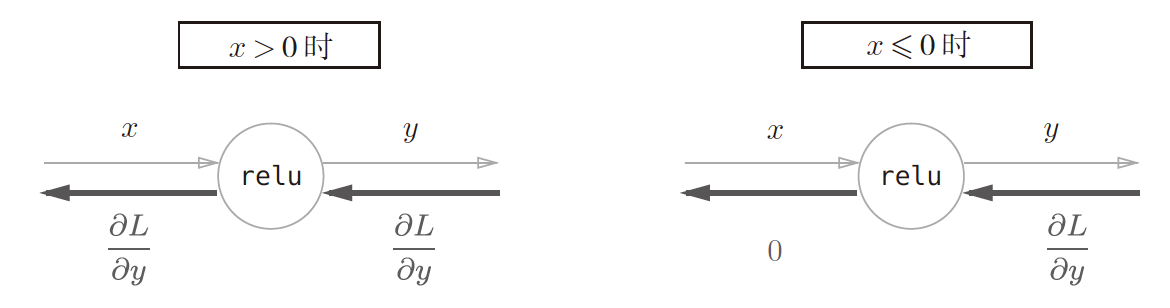

In [3]:
class ReLU:
    
    def __init__(self):
        self.mask = None # 由True/False构成的数组
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0 # x<=0时y=0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0 # 正向传播时x<=0的，反向传播时信号止于此
        dx = dout
        return dx

In [4]:
import numpy as np

x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)
mask = (x <= 0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


> ReLU 层的作用就像电路中的开关一样。
>
> 正向传播时，有电流通过的话，就将开关设为ON；没有电流通过的话，就将开关设为OFF。
>
> 反向传播时，开关为ON 的话，电流会直接通过；开关为OFF 的话，则不会有电流通过。

### sigmoid层的实现

sigmoid函数如下：$$y=\frac{1}{1+\exp (-x)}$$ 用计算图表示的话如下：

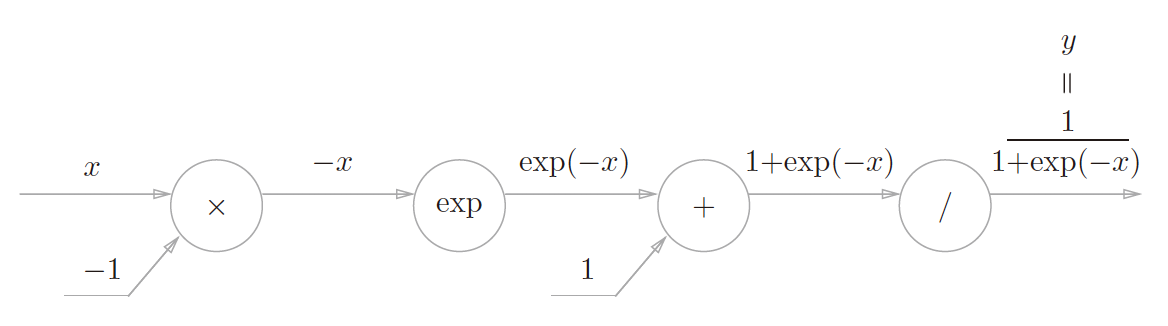

除了加法和乘法外，还出现了"exp"节点和"/"节点。"exp"节点会进行 $y=\exp (x)$ 的计算，"/"节点会进行倒数计算 $y=\frac{1}{x}$

#### 步骤1

"/"节点会进行计算倒数的计算，$y=\frac{1}{x}$ 的导数可以解析为 $$\begin{aligned} \frac{\partial y}{\partial x} &=-\frac{1}{x^{2}} \\ &=-y^{2} \end{aligned}$$

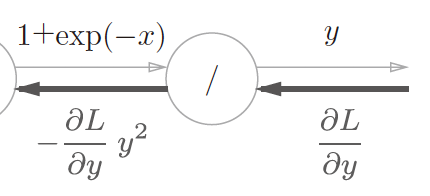

#### 步骤2

"+"节点将上游值原封不动传给下游

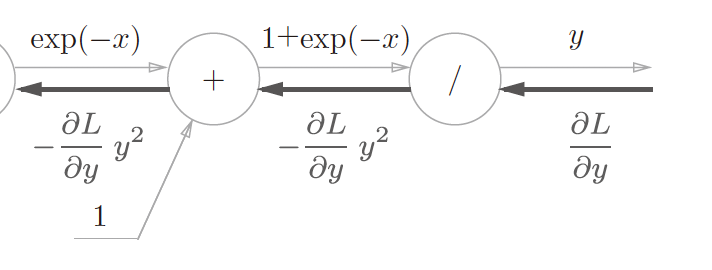

#### 步骤3

"exp"节点表示 $y=\exp (x)$ ， 它的导数如下：$$\frac{\partial y}{\partial x}=\exp (x)$$

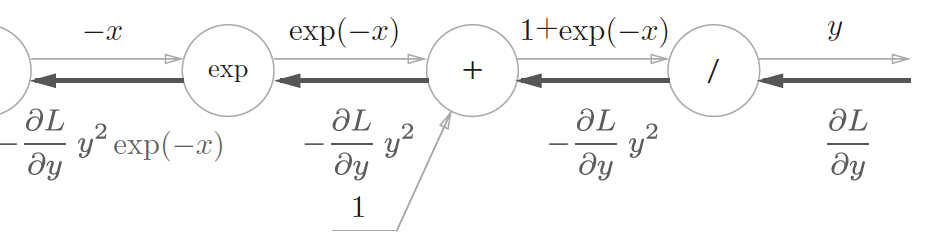

#### 步骤4

乘法节点将正向传播时的值翻转，传递给下游

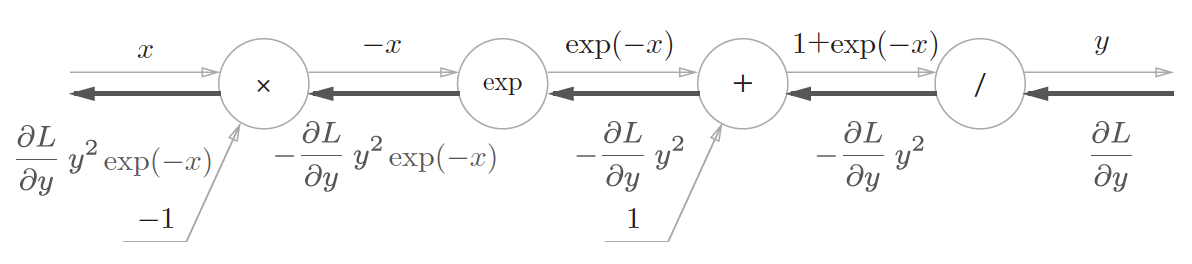

最终，sigmoid层的计算图如下：

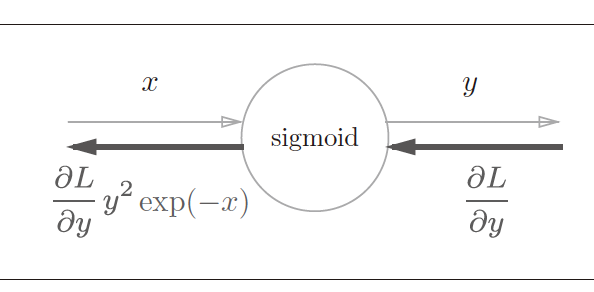

进一步整理 $\frac{\partial L}{\partial y} y^{2} \exp (-x)$ $$\begin{aligned} \frac{\partial L}{\partial y} y^{2} \exp (-x) &=\frac{\partial L}{\partial y} \frac{1}{(1+\exp (-x))^{2}} \exp (-x) \\ &=\frac{\partial L}{\partial y} \frac{1}{1+\exp (-x)} \frac{\exp (-x)}{1+\exp (-x)} \\ &=\frac{\partial L}{\partial y} y(1-y) \end{aligned}$$

最终，Sigmoid 层的反向传播，只根据正向传播的输出就能计算出来。

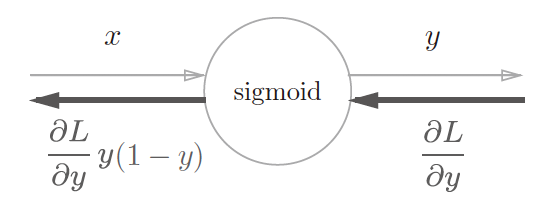

In [5]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out # 记录正向传播的输出，为反向传播做准备
        return out
    
    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        return dx

## 仿射变换层 Affine Layer

神经网络的正向传播中进行的矩阵的乘积运算在几何学领域被称为“仿射变换”

np.dot(X, W) + B的运算可用下图表示：

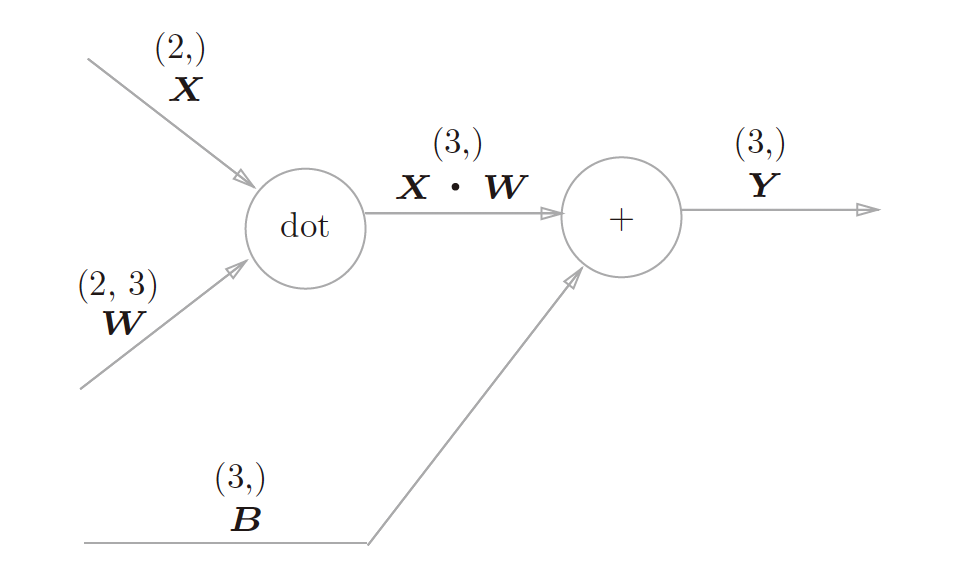

反向传播时，按矩阵的各个元素进行计算，步骤和以标量为对象的计算图相同。(省略推导过程) $$\frac{\partial L}{\partial \boldsymbol{X}}=\frac{\partial L}{\partial \boldsymbol{Y}} \cdot \boldsymbol{W}^{\mathrm{T}}$$ $$\frac{\partial L}{\partial \boldsymbol{W}}=\boldsymbol{X}^{\mathrm{T}} \cdot \frac{\partial L}{\partial \boldsymbol{Y}}$$

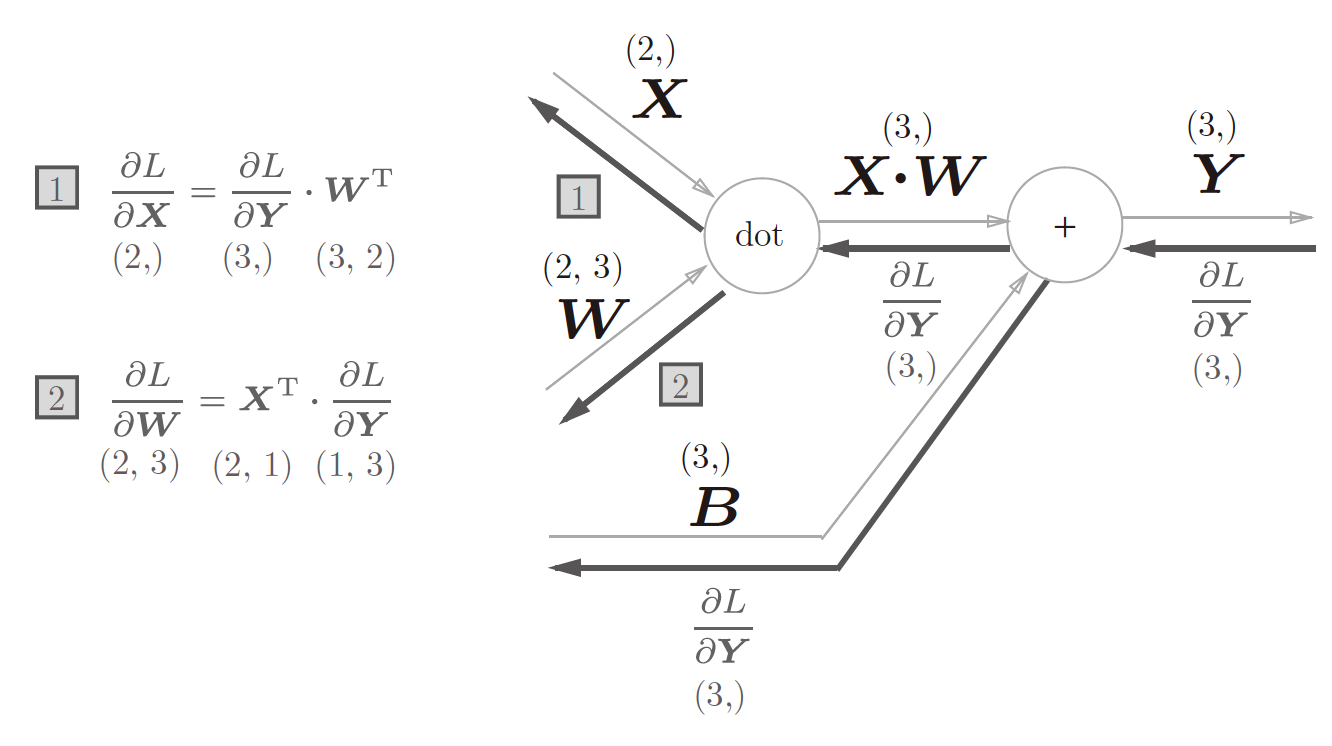

对矩阵求导，就是对矩阵中每个元素求导

$$\boldsymbol{X}=\left(x_{0}, x_{1}, \cdots, x_{n}\right)$$ $$\frac{\partial L}{\partial \boldsymbol{X}}=\left(\frac{\partial L}{\partial x_{0}}, \frac{\partial L}{\partial x_{1}}, \cdots, \frac{\partial L}{\partial x_{n}}\right)$$

矩阵的乘积（“dot”节点）的反向传播可以通过组建使矩阵对应维度的元素个数一致的乘积运算而推导出来

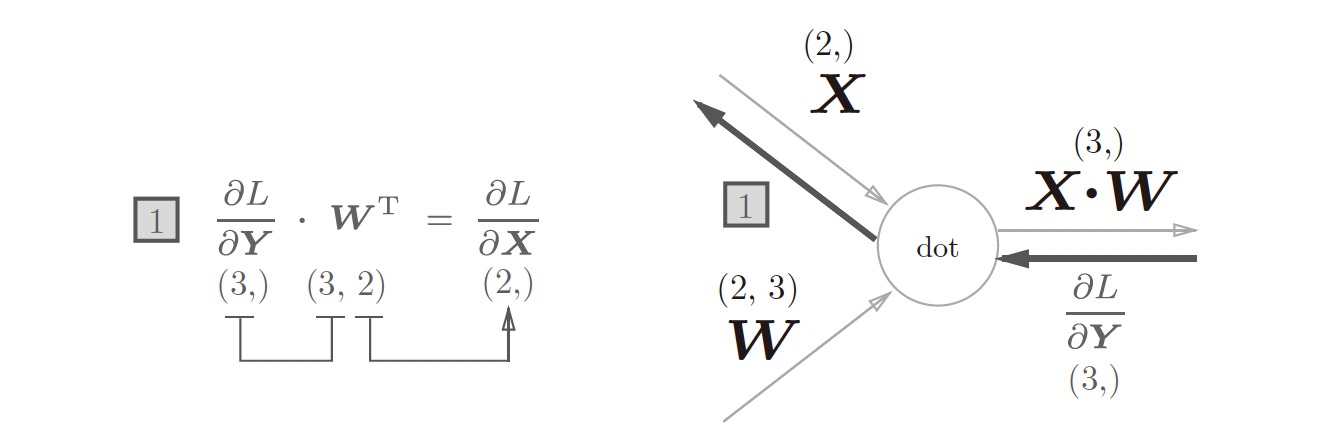

上面输入 $X$ 是单个数据为对象，下面考虑N个数据一起进行正向传播：

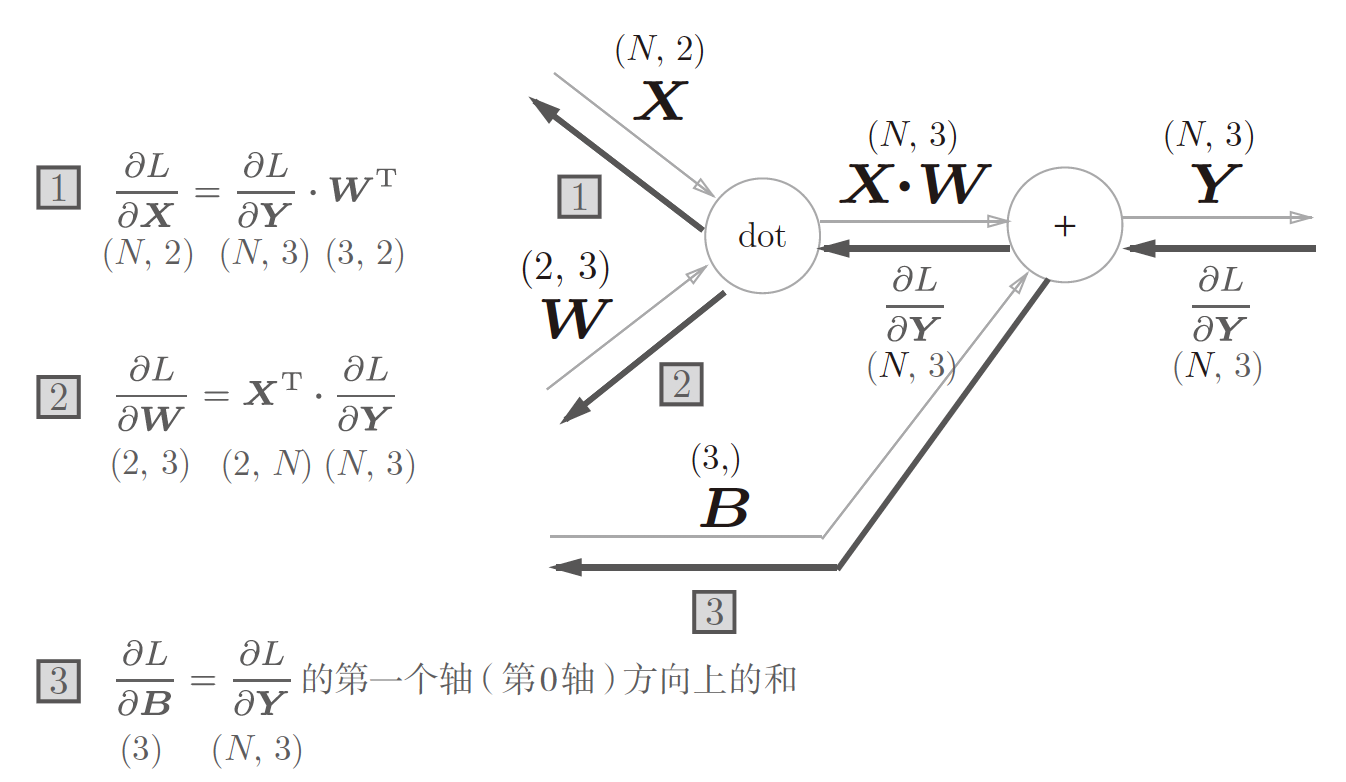

In [6]:
import numpy as np

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

## Softmax-with-Loss 层

Softmax-with-Loss层的计算图如下：(直接简化)

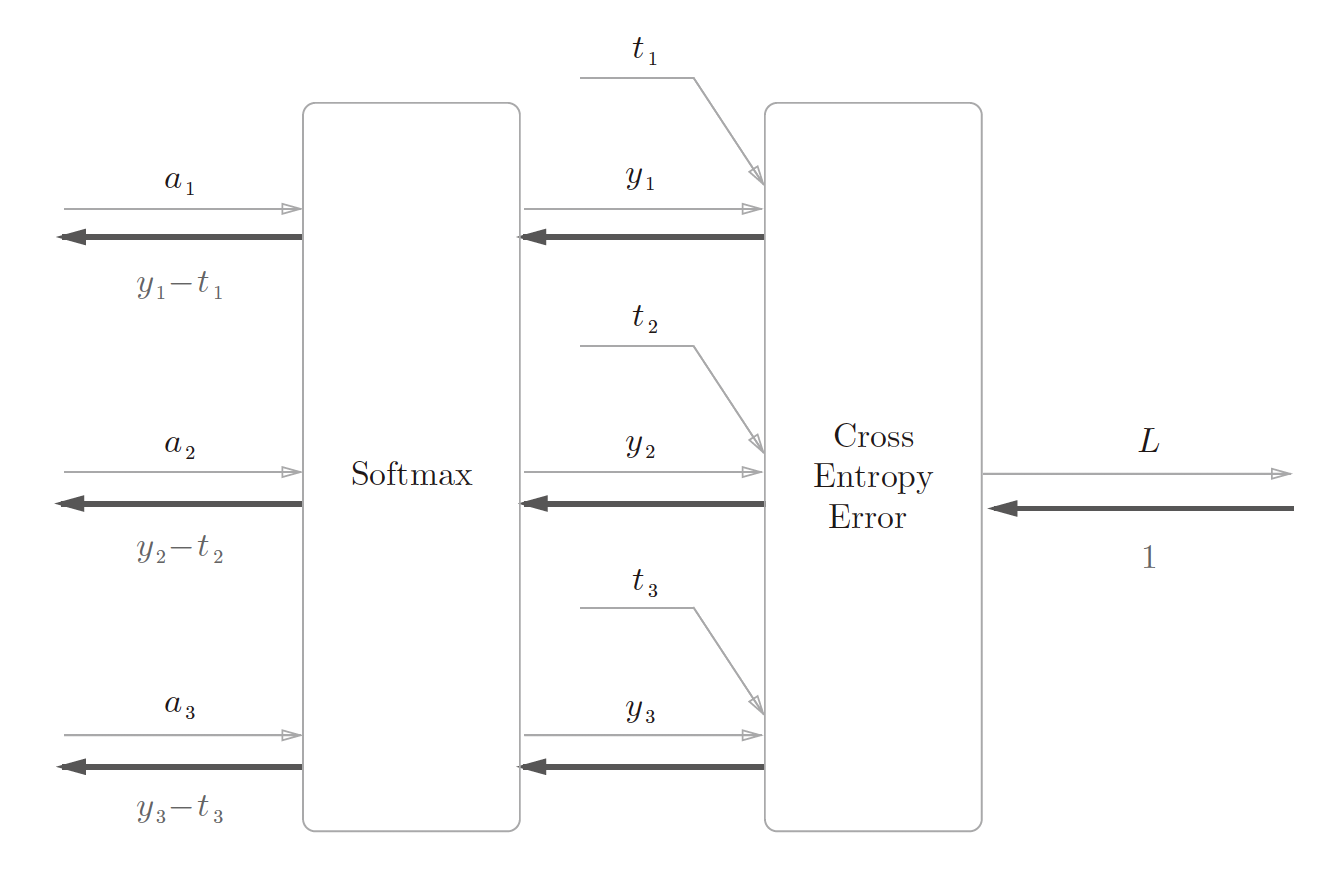

可以看到，Softmax层反向传播得到的结果是 $\left(y_{1}-t_{1}, y_{2}-t_{2}, y_{3}-t_{3}\right)$ ，$\left(y_{1}, y_{2}, y_{3}\right)$ 是softmax层的输出，$\left(t_{1}, t_{2}, t_{3}\right)$ 是监督数据

神经网络学习的目的就是通过调整权重参数，使神经网络的输出（Softmax的输出）接近教师标签。因此，必须将神经网络的输出与正确标签的误差高效地传递给前面的层。刚刚的 $\left(y_{1}-t_{1}, y_{2}-t_{2}, y_{3}-t_{3}\right)$ ，$\left(y_{1}, y_{2}, y_{3}\right)$ 正是Softmax层的输出与正确标签的差，直截了当地表示了当前神经网络的输出与教师标签的误差

举两个例子：

1. 比如思考教师标签是（0, 1, 0），Softmax 层的输出是(0.3, 0.2, 0.5) 的情形。因为正确解标签处的概率是0.2（20%），这个时候的神经网络未能进行正确的识别。此时，Softmax 层的反向传播传递的是(0.3, −0.8, 0.5) 这样一个大的误差。因为这个大的误差会向前面的层传播，所以Softmax层前面的层会从这个大的误差中学习到“大”的内容。

2. 比如思考教师标签是(0, 1, 0)，Softmax层的输出是(0.01,0.99, 0)的情形（这个神经网络识别得相当准确）。此时Softmax层的反向传播传递的是(0.01, −0.01, 0) 这样一个小的误差。这个小的误差也会向前面的层传播，因为误差很小，所以Softmax层前面的层学到的内容也很“小”。

In [7]:
from common.functions import softmax, cross_entropy_error

class SoftmaxWithLoss:
    
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size # 传递给前面的层的是单个数据的误差
        
        return dx

## 训练神经网络的过程

In [1]:
import numpy as np
from common.gradient import numerical_gradient
from common.layers import Affine, ReLU, SoftmaxWithLoss
from collections import OrderedDict

# 定义神经网络的结构
class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    # x: 输入数据； t: 监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # 数值微分法求梯度
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    # 反向传播法求梯度
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        
        return grads

回顾一下训练神经网络的步骤如下：

1. 步骤1（mini-batch）从训练数据中随机选择一部分数据。

2. 步骤2（计算梯度）计算损失函数关于各个权重参数的梯度。

3. 步骤3（更新参数）将权重参数沿梯度方向进行微小的更新。

4. 步骤4（重复）重复步骤1、步骤2、步骤3。

In [2]:
import sys, os
import numpy as np
from dataset.mnist import load_mnist
# from two_layer_net import TwoLayerNet

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 通过误差反向传播法求梯度
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.10378333333333334 0.1098
0.90325 0.9064
0.9237833333333333 0.9245
0.9341833333333334 0.936
0.9427 0.941
0.9499 0.9463
0.9557166666666667 0.951
0.9598333333333333 0.9553
0.9629 0.9581
0.9661333333333333 0.9609
0.9683833333333334 0.9616
0.9686333333333333 0.9623
0.9713 0.9647
0.9741333333333333 0.9675
0.975 0.9675
0.9759666666666666 0.9666
0.9754333333333334 0.966


## 总结

- 通过使用计算图，可以直观地把握计算过程。
- 计算图的节点是由局部计算构成的。局部计算构成全局计算。
- 计算图的正向传播进行一般的计算。通过计算图的反向传播，可以计算各个节点的导数。
- 通过将神经网络的组成元素实现为层，可以高效地计算梯度（反向传播法）。
- 通过比较数值微分和误差反向传播法的结果，可以确认误差反向传播法的实现是否正确（梯度确认）。